In [21]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [25]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torchmetrics import MeanSquaredError
import matplotlib.pyplot as plt

In [2]:
from google.colab import files

uploaded = files.upload()

Saving weather.csv to weather.csv


In [15]:
class WeatherDataset(Dataset):
    def __init__(self, df_path, sequence_length=3, target_col='Maximum temperature (Degree C)',
                 feature_cols=['Rainfall amount (millimetres)', 'Maximum temperature (Degree C)']):
        df = pd.read_csv(df_path)
        df['Date'] = pd.to_datetime(df['Date'])
        df.sort_values('Date', inplace=True)

        self.features = df[feature_cols].values
        self.target = df[target_col].values

        self.scaler_features = MinMaxScaler()
        self.scaler_target = MinMaxScaler()

        self.features_norm = self.scaler_features.fit_transform(self.features)
        self.target_norm = self.scaler_target.fit_transform(self.target.reshape(-1, 1))

        self.X, self.y = self.create_sequences(
            self.features_norm,
            self.target_norm,
            sequence_length
        )

        self.X = torch.FloatTensor(self.X)
        self.y = torch.FloatTensor(self.y)

    def create_sequences(self, data, target, seq_length):
        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:i+seq_length])
            y.append(target[i+seq_length])
        return np.array(X), np.array(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

    def inverse_transform_target(self, y):
        return self.scaler_target.inverse_transform(y.cpu().numpy())

    def get_feature_scaler(self):
        return self.scaler_features

    def get_target_scaler(self):
        return self.scaler_target

In [16]:
dataset = WeatherDataset("weather.csv", sequence_length=2)

train_size = int(len(dataset) * 0.6)
val_size = int(len(dataset) * 0.2)
test_size = len(dataset) - (train_size + val_size)

dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=8, pin_memory=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [39]:
class TemperatureGRU(nn.Module):
    def __init__(self, input_size, num_layers=1):
        super(TemperatureGRU, self).__init__()
        self.rnn = nn.GRU(input_size, 32, 1, batch_first=True)
        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TemperatureGRU(input_size=dataset.features_norm.shape[1]).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)



Epoch 1/50:   0%|          | 0/37 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 1/50: 100%|██████████| 37/37 [00:00<00:00, 48.43it/s]


Epoch 1, Train Loss: 0.0321, Train RMSE: 0.1794, Val Loss: 0.0214, Val RMSE: 0.1448
✔ Model improved. Saved to gru_regression.pth


Epoch 2/50: 100%|██████████| 37/37 [00:00<00:00, 48.61it/s]


Epoch 2, Train Loss: 0.0173, Train RMSE: 0.1316, Val Loss: 0.0176, Val RMSE: 0.1304
✔ Model improved. Saved to gru_regression.pth


Epoch 3/50: 100%|██████████| 37/37 [00:00<00:00, 61.25it/s]


Epoch 3, Train Loss: 0.0165, Train RMSE: 0.1285, Val Loss: 0.0174, Val RMSE: 0.1295
✔ Model improved. Saved to gru_regression.pth


Epoch 4/50: 100%|██████████| 37/37 [00:00<00:00, 62.40it/s]


Epoch 4, Train Loss: 0.0162, Train RMSE: 0.1275, Val Loss: 0.0167, Val RMSE: 0.1272
✔ Model improved. Saved to gru_regression.pth


Epoch 5/50: 100%|██████████| 37/37 [00:00<00:00, 62.25it/s]


Epoch 5, Train Loss: 0.0163, Train RMSE: 0.1277, Val Loss: 0.0174, Val RMSE: 0.1295


Epoch 6/50: 100%|██████████| 37/37 [00:00<00:00, 61.15it/s]


Epoch 6, Train Loss: 0.0164, Train RMSE: 0.1278, Val Loss: 0.0166, Val RMSE: 0.1270
✔ Model improved. Saved to gru_regression.pth


Epoch 7/50: 100%|██████████| 37/37 [00:00<00:00, 60.71it/s]


Epoch 7, Train Loss: 0.0159, Train RMSE: 0.1264, Val Loss: 0.0163, Val RMSE: 0.1259
✔ Model improved. Saved to gru_regression.pth


Epoch 8/50: 100%|██████████| 37/37 [00:00<00:00, 61.58it/s]


Epoch 8, Train Loss: 0.0162, Train RMSE: 0.1273, Val Loss: 0.0167, Val RMSE: 0.1272


Epoch 9/50: 100%|██████████| 37/37 [00:00<00:00, 60.56it/s]


Epoch 9, Train Loss: 0.0158, Train RMSE: 0.1258, Val Loss: 0.0169, Val RMSE: 0.1279


Epoch 10/50: 100%|██████████| 37/37 [00:00<00:00, 40.20it/s]


Epoch 10, Train Loss: 0.0158, Train RMSE: 0.1259, Val Loss: 0.0168, Val RMSE: 0.1278


Epoch 11/50: 100%|██████████| 37/37 [00:00<00:00, 40.41it/s]


Epoch 11, Train Loss: 0.0160, Train RMSE: 0.1266, Val Loss: 0.0156, Val RMSE: 0.1237
✔ Model improved. Saved to gru_regression.pth


Epoch 12/50: 100%|██████████| 37/37 [00:00<00:00, 61.20it/s]


Epoch 12, Train Loss: 0.0154, Train RMSE: 0.1242, Val Loss: 0.0163, Val RMSE: 0.1265


Epoch 13/50: 100%|██████████| 37/37 [00:00<00:00, 61.91it/s]


Epoch 13, Train Loss: 0.0154, Train RMSE: 0.1241, Val Loss: 0.0154, Val RMSE: 0.1228
✔ Model improved. Saved to gru_regression.pth


Epoch 14/50: 100%|██████████| 37/37 [00:00<00:00, 63.64it/s]


Epoch 14, Train Loss: 0.0153, Train RMSE: 0.1234, Val Loss: 0.0153, Val RMSE: 0.1230
✔ Model improved. Saved to gru_regression.pth


Epoch 15/50: 100%|██████████| 37/37 [00:00<00:00, 62.47it/s]


Epoch 15, Train Loss: 0.0153, Train RMSE: 0.1238, Val Loss: 0.0157, Val RMSE: 0.1244


Epoch 16/50: 100%|██████████| 37/37 [00:00<00:00, 63.20it/s]


Epoch 16, Train Loss: 0.0151, Train RMSE: 0.1229, Val Loss: 0.0156, Val RMSE: 0.1238


Epoch 17/50: 100%|██████████| 37/37 [00:00<00:00, 62.47it/s]


Epoch 17, Train Loss: 0.0155, Train RMSE: 0.1242, Val Loss: 0.0168, Val RMSE: 0.1289


Epoch 18/50: 100%|██████████| 37/37 [00:00<00:00, 62.30it/s]


Epoch 18, Train Loss: 0.0150, Train RMSE: 0.1223, Val Loss: 0.0155, Val RMSE: 0.1243


Epoch 19/50: 100%|██████████| 37/37 [00:00<00:00, 62.25it/s]


Epoch 19, Train Loss: 0.0150, Train RMSE: 0.1224, Val Loss: 0.0173, Val RMSE: 0.1306


Epoch 20/50: 100%|██████████| 37/37 [00:00<00:00, 62.02it/s]


Epoch 20, Train Loss: 0.0151, Train RMSE: 0.1231, Val Loss: 0.0168, Val RMSE: 0.1287


Epoch 21/50: 100%|██████████| 37/37 [00:00<00:00, 43.11it/s]


Epoch 21, Train Loss: 0.0153, Train RMSE: 0.1234, Val Loss: 0.0160, Val RMSE: 0.1258


Epoch 22/50: 100%|██████████| 37/37 [00:00<00:00, 39.16it/s]


Epoch 22, Train Loss: 0.0156, Train RMSE: 0.1248, Val Loss: 0.0179, Val RMSE: 0.1327


Epoch 23/50: 100%|██████████| 37/37 [00:00<00:00, 61.86it/s]


Epoch 23, Train Loss: 0.0153, Train RMSE: 0.1237, Val Loss: 0.0161, Val RMSE: 0.1261


Epoch 24/50: 100%|██████████| 37/37 [00:00<00:00, 62.68it/s]


Epoch 24, Train Loss: 0.0157, Train RMSE: 0.1254, Val Loss: 0.0154, Val RMSE: 0.1233
Early stopping triggered!
✅ Best model loaded from gru_regression.pth
Test Loss: 0.0140, Test RMSE: 0.1200


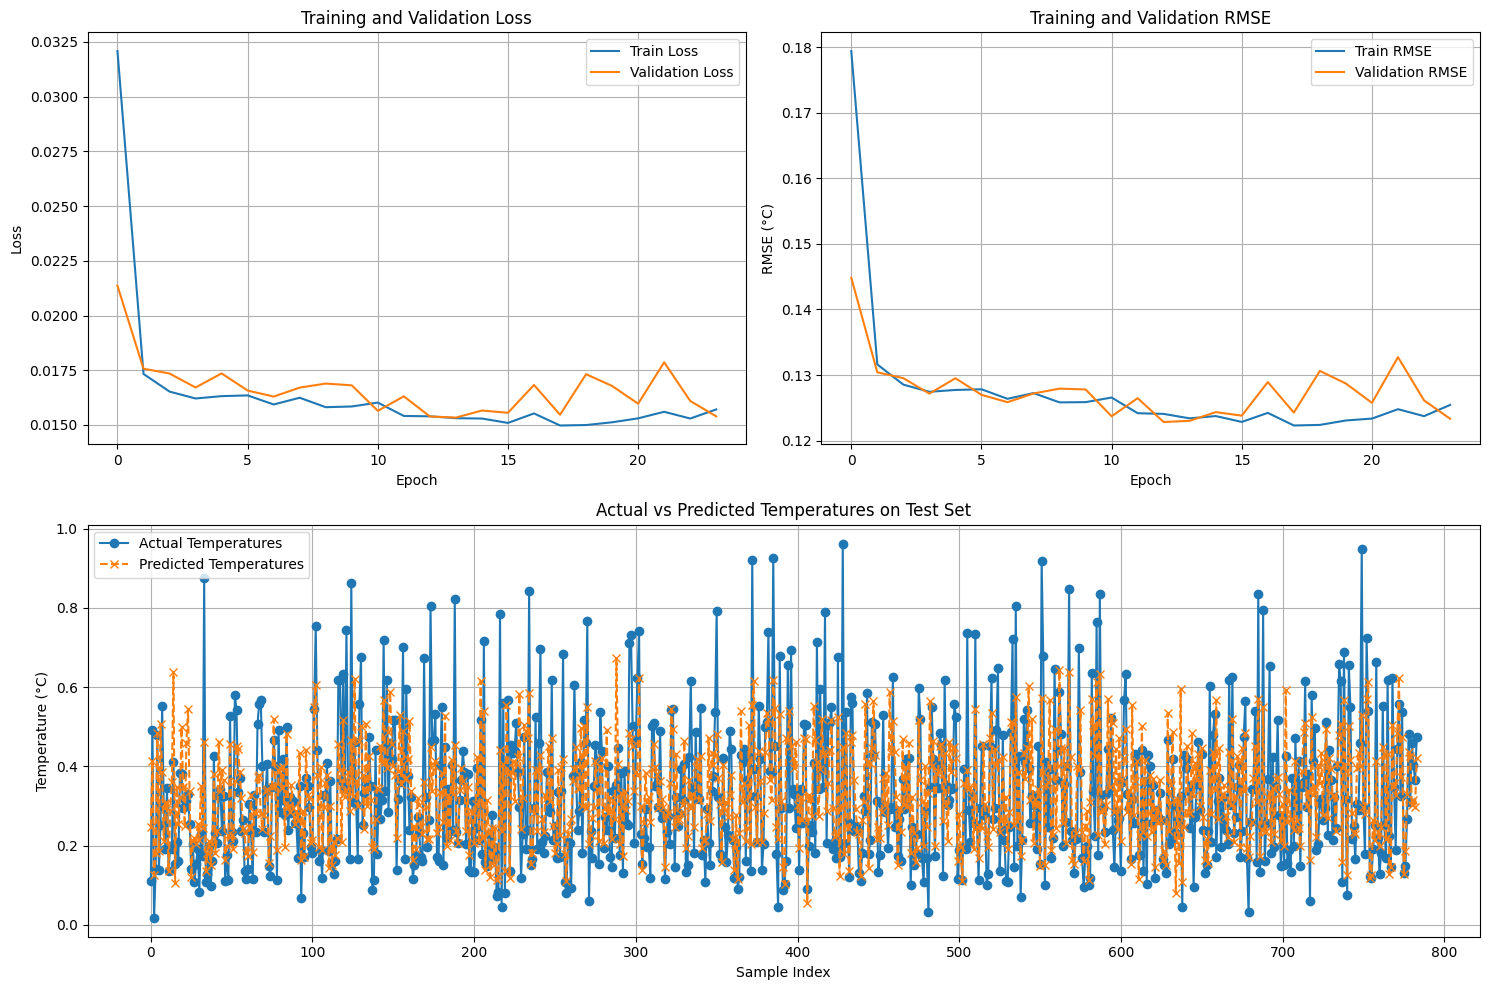

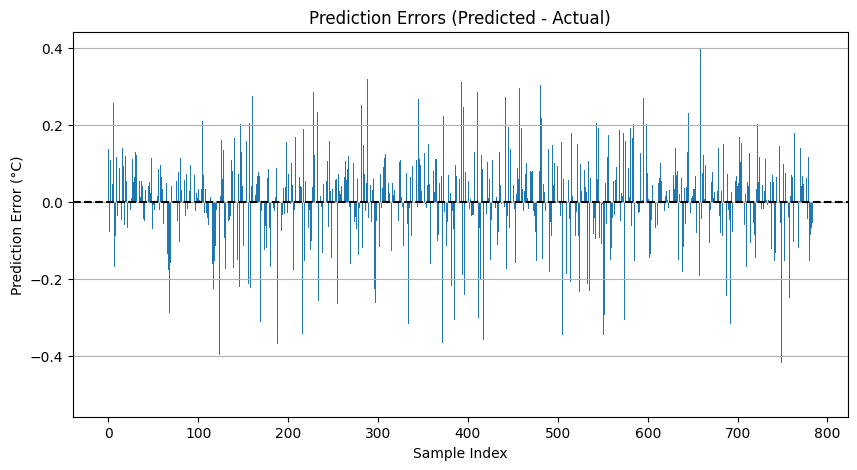

In [41]:
train_loss_history = []
val_loss_history = []
train_rmse_history = []
val_rmse_history = []
test_predictions = []
test_actuals = []

epochs = 50
patience = 10
best_val_loss = float("inf")
patience_counter = 0
model_path = "gru_regression.pth"

rmse = MeanSquaredError(squared=False).to(device)

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    rmse.reset()

    for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        rmse.update(outputs, y_batch)

    train_loss = running_loss / len(train_loader)
    train_rmse = rmse.compute().item()
    train_loss_history.append(train_loss)
    train_rmse_history.append(train_rmse)

    model.eval()
    val_loss = 0.0
    rmse.reset()

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            rmse.update(outputs, y_batch)

    val_loss /= len(val_loader)
    val_rmse = rmse.compute().item()
    val_loss_history.append(val_loss)
    val_rmse_history.append(val_rmse)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train RMSE: {train_rmse:.4f}, Val Loss: {val_loss:.4f}, Val RMSE: {val_rmse:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), model_path)
        print(f"✔ Model improved. Saved to {model_path}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

model.load_state_dict(torch.load(model_path))
model.to(device)
print(f"✅ Best model loaded from {model_path}")

model.eval()
test_loss = 0.0
rmse.reset()

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item()
        rmse.update(outputs, y_batch)

        test_predictions.extend(outputs.cpu().numpy().flatten())
        test_actuals.extend(y_batch.cpu().numpy().flatten())

test_loss /= len(test_loader)
test_rmse = rmse.compute().item()
print(f"Test Loss: {test_loss:.4f}, Test RMSE: {test_rmse:.4f}")

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(train_rmse_history, label='Train RMSE')
plt.plot(val_rmse_history, label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE (°C)')
plt.title('Training and Validation RMSE')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, (3,4))
plt.plot(test_actuals, 'o-', label='Actual Temperatures')
plt.plot(test_predictions, 'x--', label='Predicted Temperatures')
plt.xlabel('Sample Index')
plt.ylabel('Temperature (°C)')
plt.title('Actual vs Predicted Temperatures on Test Set')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
errors = np.array(test_predictions) - np.array(test_actuals)
plt.bar(range(len(errors)), errors)
plt.xlabel('Sample Index')
plt.ylabel('Prediction Error (°C)')
plt.title('Prediction Errors (Predicted - Actual)')
plt.axhline(y=0, color='black', linestyle='--')
plt.grid(True, axis='y')
plt.show()